In [1]:
import sys
sys.path.append('../')

from src.HydraulicConductanceModels.cumulative_Weibull_distribution_model import cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials, CumulativeWeibullDistribution
from src.leaf_air_coupling_model import LeafAirCouplingModel
from src.rubisco_CO2_and_O_model import RubiscoRates
from src.electron_transport_rate_model import ElectronTransportRateModel

# -- Photosynthesis models --
from src.PhotosynthesisModels.photosynthesis_model import PhotosynthesisModel
#from src.PhotosynthesisModels.Bonan_Model import PhotosynthesisModelRubiscoLimitedBonan as PhotosynthesisModelRubiscoLimited
#from src.PhotosynthesisModels.Bonan_Model import PhotosynthesisModelElectronTransportLimitedBonan as PhotosynthesisModelElectronTransportLimited
from src.PhotosynthesisModels.Leuning_Model import PhotosynthesisModelRubiscoLimitedLeuning as PhotosynthesisModelRubiscoLimited
from src.PhotosynthesisModels.Leuning_Model import PhotosynthesisModelElectronTransportLimitedLeuning as PhotosynthesisModelElectronTransportLimited

# -- Temperature dependency models --
from src.TemperatureDependenceModels.arrhenius_and_peaked_arrhenius_function import ArrheniusModel, PeakedArrheniusModel
from src.TemperatureDependenceModels.Q10_temperature_dependence_model import Q10TemperatureDependenceModel
from src.TemperatureDependenceModels.temperature_dependence_model import LowTemperatureAdjustedModel

# -- Profit Models --
from src.ProfitModels.CO2GainModels.CO2_gain_profit_max_model import ProfitMaxCO2GainModel as CO2GainModel
from src.ProfitModels.HydraulicCostModels.hydraulic_cost_profit_max_model import ProfitMaxHydraulicCostModel as HydraulicCostModel
from src.ProfitModels.profit_max_model import ProfitMaxModel
from src.ProfitModels.profit_optimisation_model import run_optimisation_model_on_data

from src.conversions import degrees_centigrade_to_kelvin

from numpy import linspace, zeros
from numpy import nanargmax
from matplotlib import pyplot as plt

# Introduction
The purpose fo this notebook is to plot the relationship between the leaf water potential, $\psi_l$ and the internal CO2 concentration, $c_i$.

The code below is used to setup the leaf model.

In [2]:
# Hydraulic conductance model.

P50 = -3 # MPa
P88 = -4 # MPa
k_max = 1 # mmol m-2 s-1 MPa-1

conductance_model = cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials(k_max,
                                                                                                    P50,
                                                                                                    P88,
                                                                                                    0.5,
                                                                                                    0.88)

In [3]:
# Create hydraulic cost model

# Water potential range
soil_water_potential = 0 # MPa
critical_water_potential = conductance_model.water_potential_from_conductivity_loss_fraction(0.95) # MPa

hydraulic_cost_model = HydraulicCostModel(conductance_model, critical_water_potential)

In [4]:
# Leaf to air cupling model
air_temperature = degrees_centigrade_to_kelvin(25.)
air_vapour_pressure_deficit = 1 # kPa
air_pressure = 101.9 # kPa

leaf_air_coupling_model = LeafAirCouplingModel()

In [5]:
# Rubisco limited photosynthesis model
atmospheric_CO2_concentration = 419. # (umol mol-1)
intercellular_oxygen = 210.0 #(umol mol-1)

# -- Rubisco rates model --
maximum_carboxylation_rate_model = PeakedArrheniusModel(rate_at_25_centigrade = 30.,
                                                        activation_energy = 60000.,
                                                        deactivation_energy = 200000.,
                                                        entropy_term = 650.)

maximum_oxegentation_rate_model = PeakedArrheniusModel(rate_at_25_centigrade = 60.,
                                                       activation_energy = 3000.,
                                                       deactivation_energy = 200000.,
                                                       entropy_term = 650.)

michaelis_menten_constant_CO2_model = ArrheniusModel(rate_at_25_centigrade=404.9,
                                                     activation_energy=79430.0)

michaelis_menten_constant_O_model = ArrheniusModel(rate_at_25_centigrade=278.4,
                                                   activation_energy=36380.0)

rubisco_rates_model = RubiscoRates(maximum_carboxylation_rate_model,
                                   maximum_oxegentation_rate_model,
                                   michaelis_menten_constant_CO2_model,
                                   michaelis_menten_constant_O_model)

# -- CO2 compensation point --
CO2_compensation_point_model = ArrheniusModel(rate_at_25_centigrade = 42.75,
                                            activation_energy = 37830.0)

# -- mitochondrial respiration rate model --
mitochondrial_respiration_rate_model = Q10TemperatureDependenceModel(value_at_25C = 0.6,
                                                                     Q10_parameter = 2.)

# -- Rubisco limited model --
photosynthesis_model_rubisco_limited = PhotosynthesisModelRubiscoLimited(rubisco_rates_model = rubisco_rates_model,
                                                                         CO2_compensation_point_model = CO2_compensation_point_model,
                                                                         mitochondrial_respiration_rate_model = mitochondrial_respiration_rate_model)


In [6]:
# Electron transport limited photosynthesis
maximum_electron_transport_rate_model = LowTemperatureAdjustedModel(PeakedArrheniusModel(rate_at_25_centigrade = 60., 
                                                                                         activation_energy = 30000., 
                                                                                         deactivation_energy = 200000., 
                                                                                         entropy_term = 650.),
                                                                   lower_bound_C = 0.,
                                                                   upper_bound_C = 10.)

electron_transport_rate_model = ElectronTransportRateModel(curvature_parameter = 0.85,
                                                           maximum_electron_transport_rate_model = maximum_electron_transport_rate_model)

photosynthesis_model_electron_transport_limited = PhotosynthesisModelElectronTransportLimited(electron_transport_rate_model = electron_transport_rate_model,
                                                                                              CO2_compensation_point_model = CO2_compensation_point_model,
                                                                                              mitochondrial_respiration_rate_model = mitochondrial_respiration_rate_model)


In [7]:
# Full photosynthesis model
photosynthesis_model = PhotosynthesisModel(photosynthesis_rubisco_limited_model=photosynthesis_model_rubisco_limited,
                                           photosynthesis_electron_transport_limited_model=photosynthesis_model_electron_transport_limited)

In [8]:
# CO2 uptake model
CO2_gain_model = CO2GainModel(leaf_air_coupling_model,
                              photosynthesis_model)

In [9]:
# Profit optimisation model
profit_optimisation_model = ProfitMaxModel(hydraulic_cost_model, leaf_air_coupling_model, CO2_gain_model)

# Comparing $\psi_l$ to $c_i$

First the code below runst the model over a range of water potentials, calculating ci for each.

In [10]:
# Environmental conditions
atmospheric_CO2_concentration = 419. # (umol mol-1)
photosyntheticaly_acitve_radiation = 500. #(umol m-2 s-1)

# Array of water potentials
water_potentials = linspace(soil_water_potential, critical_water_potential, 1000)

profit_values, carbon_gain, hydraulic_costs, CO2_uptake, transpiration, ci, gsc, water_potentials = \
    profit_optimisation_model.profit_as_a_function_of_leaf_water_potential(soil_water_potential,
                                                                           air_temperature,
                                                                           air_vapour_pressure_deficit,
                                                                           air_pressure,
                                                                           atmospheric_CO2_concentration,
                                                                           intercellular_oxygen,
                                                                           photosyntheticaly_acitve_radiation,
                                                                           number_of_sample_points=len(water_potentials))

CO2_compensation_point = CO2_compensation_point_model.get_value_at_temperature(air_temperature)

Lets plot $\psi_l$ as a function of $c_i$.

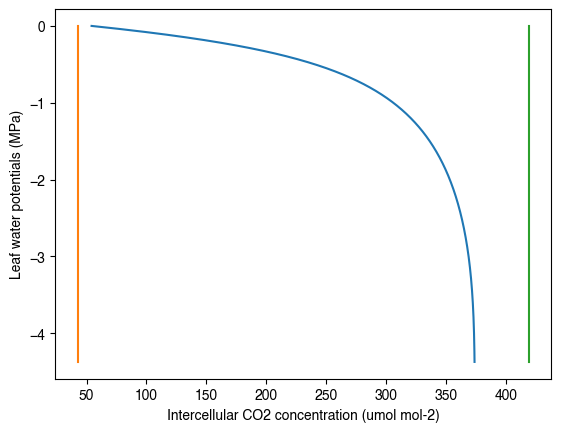

In [11]:
plt.plot(ci, water_potentials)
plt.plot([CO2_compensation_point, CO2_compensation_point], water_potentials[[0,-1]])
plt.plot([atmospheric_CO2_concentration, atmospheric_CO2_concentration], water_potentials[[0,-1]])
plt.ylabel("Leaf water potentials (MPa)")
plt.xlabel("Intercellular CO2 concentration (umol mol-2)")
plt.show()

How about transpiration as a function of $c_i$

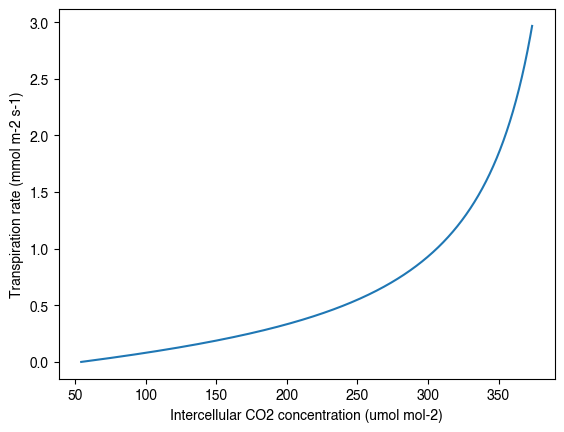

In [12]:
plt.plot(ci, transpiration)
plt.ylabel("Transpiration rate (mmol m-2 s-1)")
plt.xlabel("Intercellular CO2 concentration (umol mol-2)")
plt.show()